In [255]:
# !pip install PyPDF2 pandas

import PyPDF2
import re
import pandas as pd
from google.colab import files
import plotly.express as px
import requests
from google.colab import files
import os
import geopandas as gpd
import folium
import pandas as pd


In [256]:


pdf_filename = "ioe_entrance_2081.pdf"

# URL of the raw file in GitHub
url = 'https://raw.githubusercontent.com/rishavgautam/IOEResult2024/main/ioe_entrance_2081.pdf'

# Downloading the file
# response = requests.get(url)
# with open(pdf_filename, 'wb') as file:
#     file.write(response.content)


if not os.path.exists(pdf_filename):
    # Download the file
    response = requests.get(url)
    with open(pdf_filename, 'wb') as file:
        file.write(response.content)
else:
    print(f"File '{pdf_filename}' already exists. Skipping download.")


File 'ioe_entrance_2081.pdf' already exists. Skipping download.


In [257]:

# Function to upload file in Colab
# uploaded = files.upload()

# Function to extract text from PDF
def extract_text_from_pdf(pdf_file):
    with open(pdf_file, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text


def parse_pdf_content(content):
    lines = content.split('\n')
    data = []

    for line in lines:
        # Use regex to match lines with the structure described
        if re.match(r'^\d+\s+\d{4}-\d+\s+[\w\s]+(Male|Female)\s+.*\s+\d+', line):
            parts = line.split()

            # Extract Serial Number and Form Number
            sno = parts[0]
            form_no = parts[1]

            # Identify Gender and its position
            gender = None
            if 'Male' in parts:
                gender_index = parts.index('Male')
                gender = 'Male'
            elif 'Female' in parts:
                gender_index = parts.index('Female')
                gender = 'Female'

            # Extract Gender, District, Rank, and Remarks
            if gender:
                # Extract District and Rank
                # district = parts[gender_index + 1]
                # rank = parts[gender_index + 2]

                # # Handle Remarks (everything after Rank)
                # remarks = ' '.join(parts[gender_index + 3:]) if len(parts) > gender_index + 3 else None


                district_end_index = gender_index + 1
                while district_end_index < len(parts) and not parts[district_end_index].isdigit():
                    district_end_index += 1

                # Extract District and Rank
                district = ' '.join(parts[gender_index + 1:district_end_index])
                rank = parts[district_end_index]

                # Handle Remarks (if present)
                remarks = ' '.join(parts[district_end_index + 1:]) if len(parts) > district_end_index + 1 else None


                # Extract Name (everything between FormNo and Gender)
                name_parts = parts[2:gender_index]
                name = ' '.join(name_parts)

                # Split Name into First Name and Last Name
                name_split = name.rsplit(' ', 1)
                fname = name_split[0]
                lname = name_split[1] if len(name_split) > 1 else ""

                # Append the parsed data (8 columns in total)
                data.append([sno, form_no, fname, lname, gender, district, rank, remarks])

    return data



In [258]:
# Extract text from PDF
pdf_content = extract_text_from_pdf(pdf_filename)

# Parse the PDF content
parsed_data = parse_pdf_content(pdf_content)

# Create a DataFrame
df = pd.DataFrame(parsed_data, columns=['SNo', 'FormNo', 'FirstName', 'LastName', 'Gender', 'District', 'Rank', 'Remarks'])

# Save as CSV
csv_filename = 'ioe_entrance_results.csv'
df.to_csv(csv_filename, index=False)

# Download the CSV file
# files.download(csv_filename)

# print(f"CSV file '{csv_filename}' has been created and is ready for download.")

# Display the first few rows of the DataFrame
print(df.head())


  SNo     FormNo      FirstName   LastName  Gender   District  Rank Remarks
0   1  2081-4060          Aabha      Regmi  Female    Dhading  4896    None
1   2  2081-6419  Aabhash Kumar      Yadav    Male     Siraha  5959    None
2   3   2081-525        Aabhash  Prajapati    Male  Bhaktapur  2574    None
3   4  2081-1726      Aabhushan    Baruwal    Male    Dhading   439    None
4   5  2081-3126      Aabhushan     Pandit    Male      Kaski  2397    None


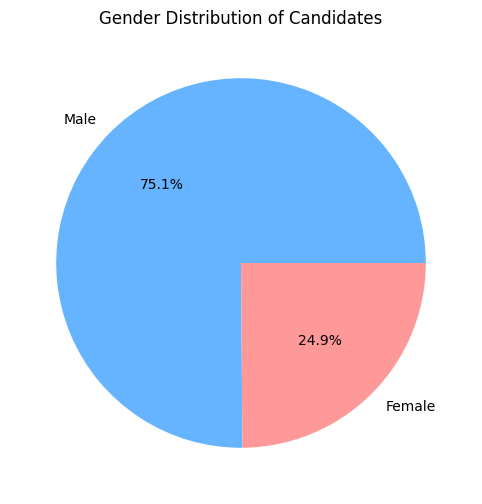

In [259]:

# 1. Gender Distribution
plt.figure(figsize=(8, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Gender Distribution of Candidates')
plt.ylabel('')
plt.show()  # Display plot in Colab

plt.close()


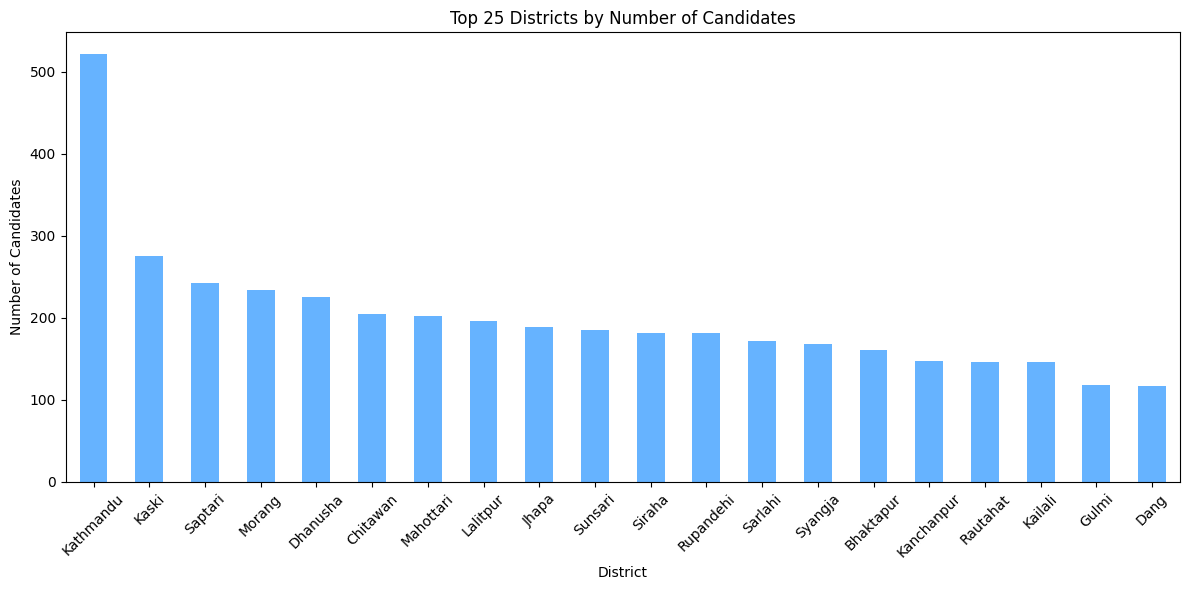

In [260]:

# 2. Top 10 Districts
plt.figure(figsize=(12, 6))
df['District'].value_counts().head(20).plot(kind='bar', color=['#66b3ff'])
plt.title('Top 25 Districts by Number of Candidates')
plt.xlabel('District')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # Display plot in Colab
plt.close()




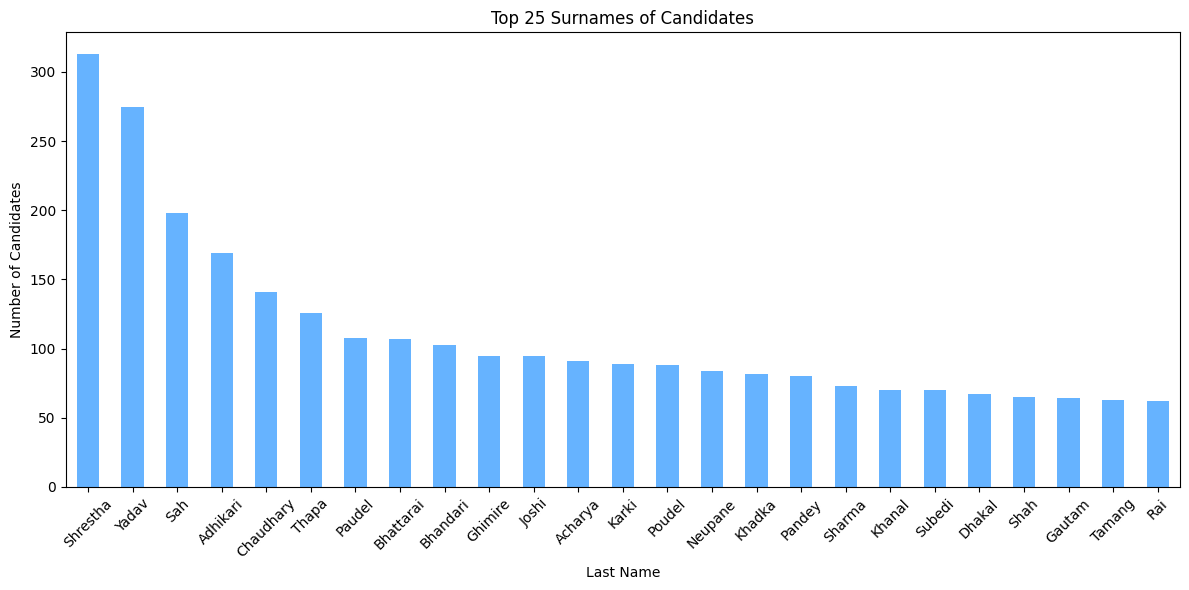

In [261]:

# 2. Top 10 Districts
plt.figure(figsize=(12, 6))
df['LastName'].value_counts().head(25).plot(kind='bar', color=['#66b3ff'])
plt.title('Top 25 Surnames of Candidates')
plt.xlabel('Last Name')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # Display plot in Colab
plt.close()


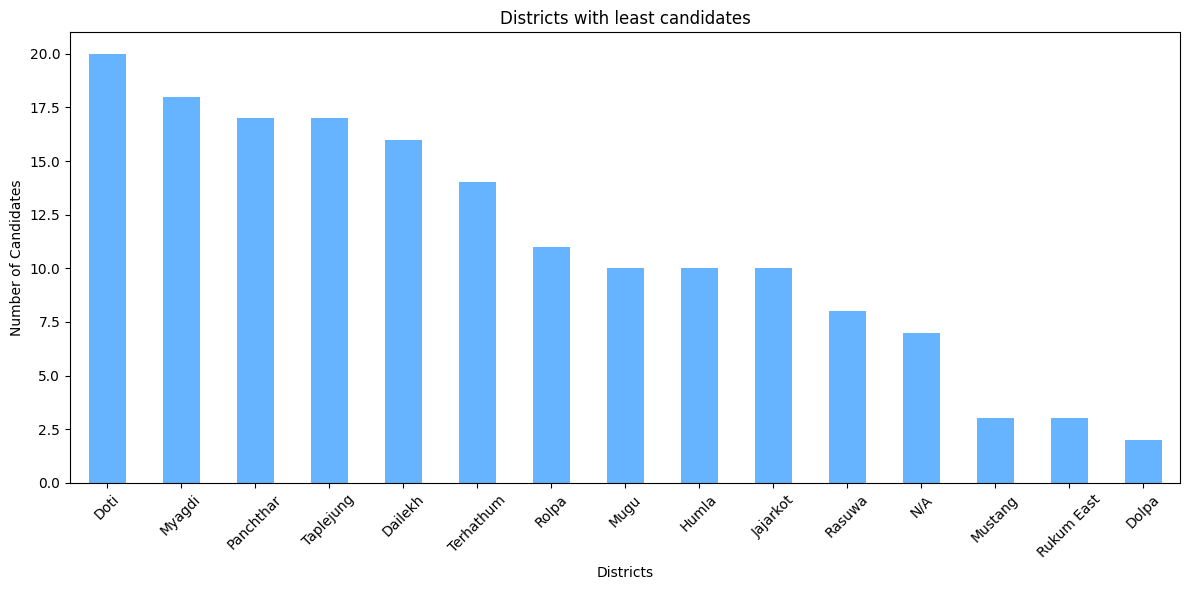

In [262]:
# 2. Top 10 Districts
plt.figure(figsize=(12, 6))
df['District'].value_counts().tail(15).plot(kind='bar', color=['#66b3ff'])
plt.title('Districts with least candidates')
plt.xlabel('Districts')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # Display plot in Colab
plt.close()


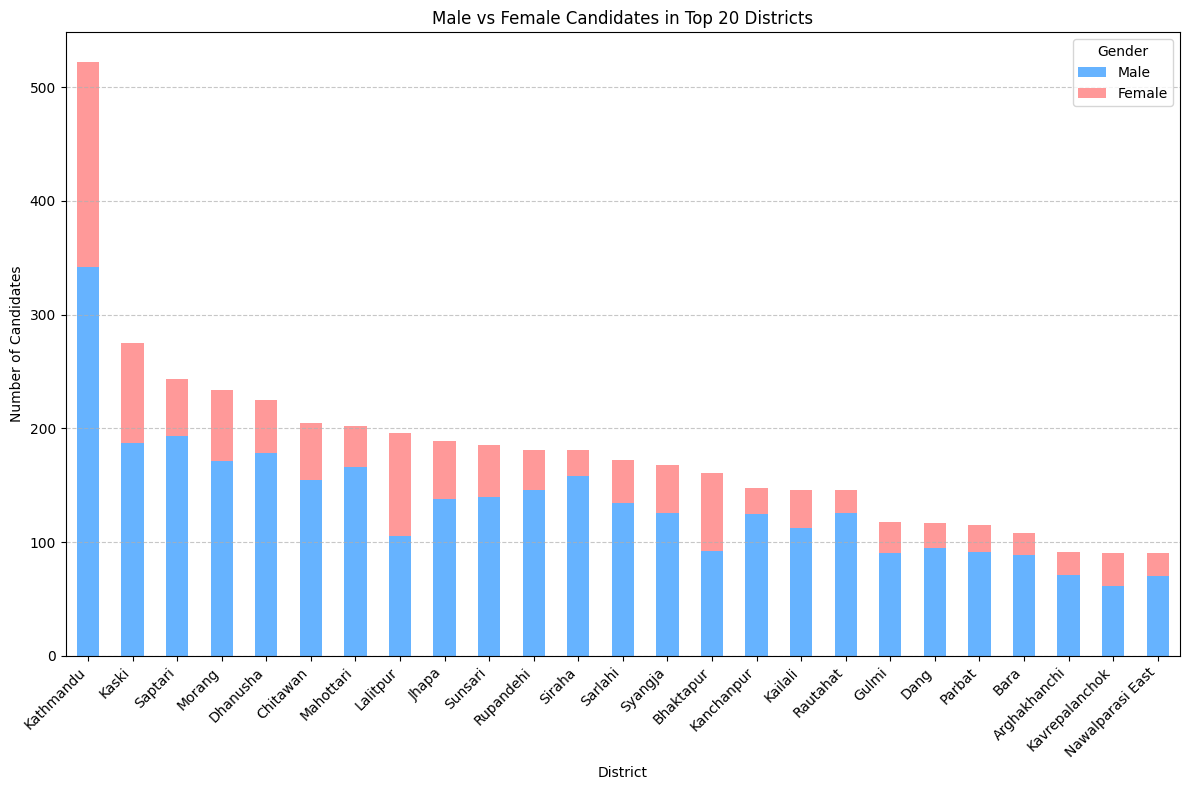

In [263]:
# Group by District and Gender, then count occurrences
gender_distribution = df.groupby(['District', 'Gender']).size().unstack(fill_value=0)

# Find total number of candidates per district
gender_distribution['Total'] = gender_distribution['Male'] + gender_distribution['Female']

# Get the top 20 districts based on total number of candidates
top_20_districts = gender_distribution.nlargest(25, 'Total')

# Plotting the comparison for top 20 districts
ax = top_20_districts[['Male', 'Female']].plot(kind='bar', figsize=(12, 8), stacked=True, color=['#66b3ff', '#ff9999'])
plt.title('Male vs Female Candidates in Top 20 Districts')
plt.xlabel('District')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()  # Display plot in Colab

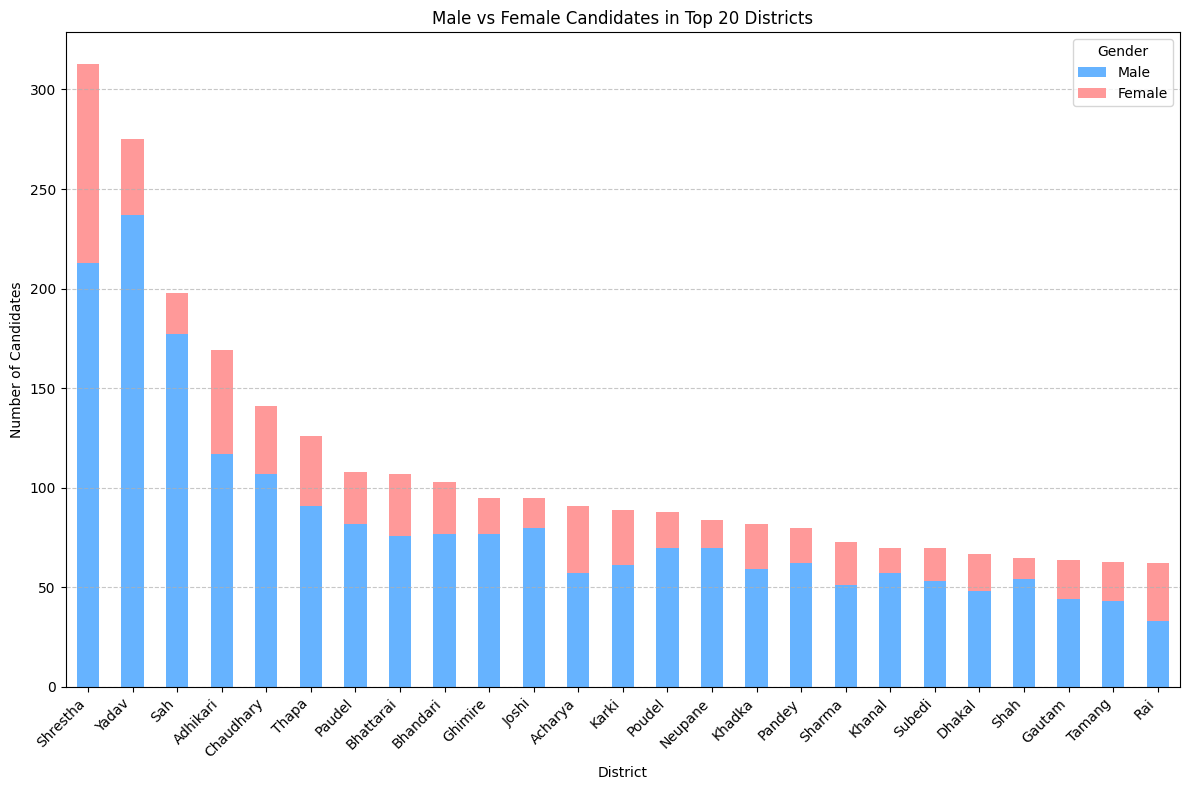

In [264]:
# Group by District and Gender, then count occurrences
gender_distribution = df.groupby(['LastName', 'Gender']).size().unstack(fill_value=0)

# Find total number of candidates per district
gender_distribution['Total'] = gender_distribution['Male'] + gender_distribution['Female']

# Get the top 20 districts based on total number of candidates
top_20_genders = gender_distribution.nlargest(25, 'Total')

# Plotting the comparison for top 20 districts
ax = top_20_genders[['Male', 'Female']].plot(kind='bar', figsize=(12, 8), stacked=True, color=['#66b3ff', '#ff9999'])
plt.title('Male vs Female Candidates in Top 20 Districts')
plt.xlabel('District')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()  # Display plot in Colab

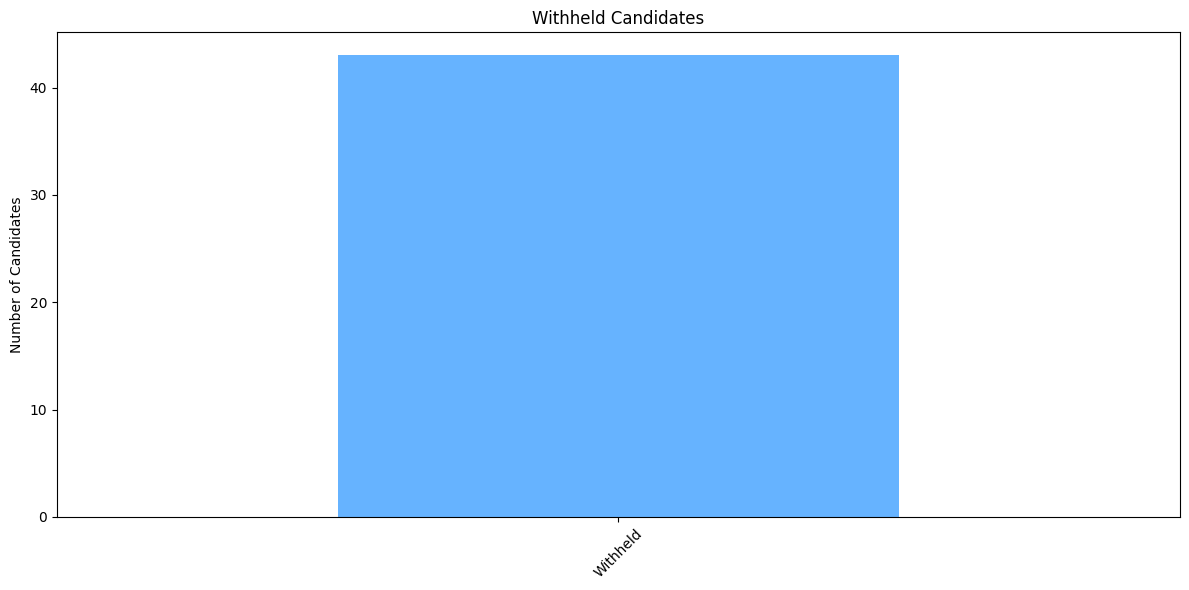

In [265]:
# 2. Top 10 Districts
plt.figure(figsize=(12, 6))
df['Remarks'].value_counts().head(100).plot(kind='bar', color="#66b3ff")
plt.title('Withheld Candidates')
plt.xlabel('')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # Display plot in Colab
plt.close()

In [266]:
# Count the occurrences of each district
district_counts = df['District'].value_counts().reset_index()
district_counts = district_counts.sort_values(by='District', ascending=False)
district_counts.columns = ['District', 'Occurrences']


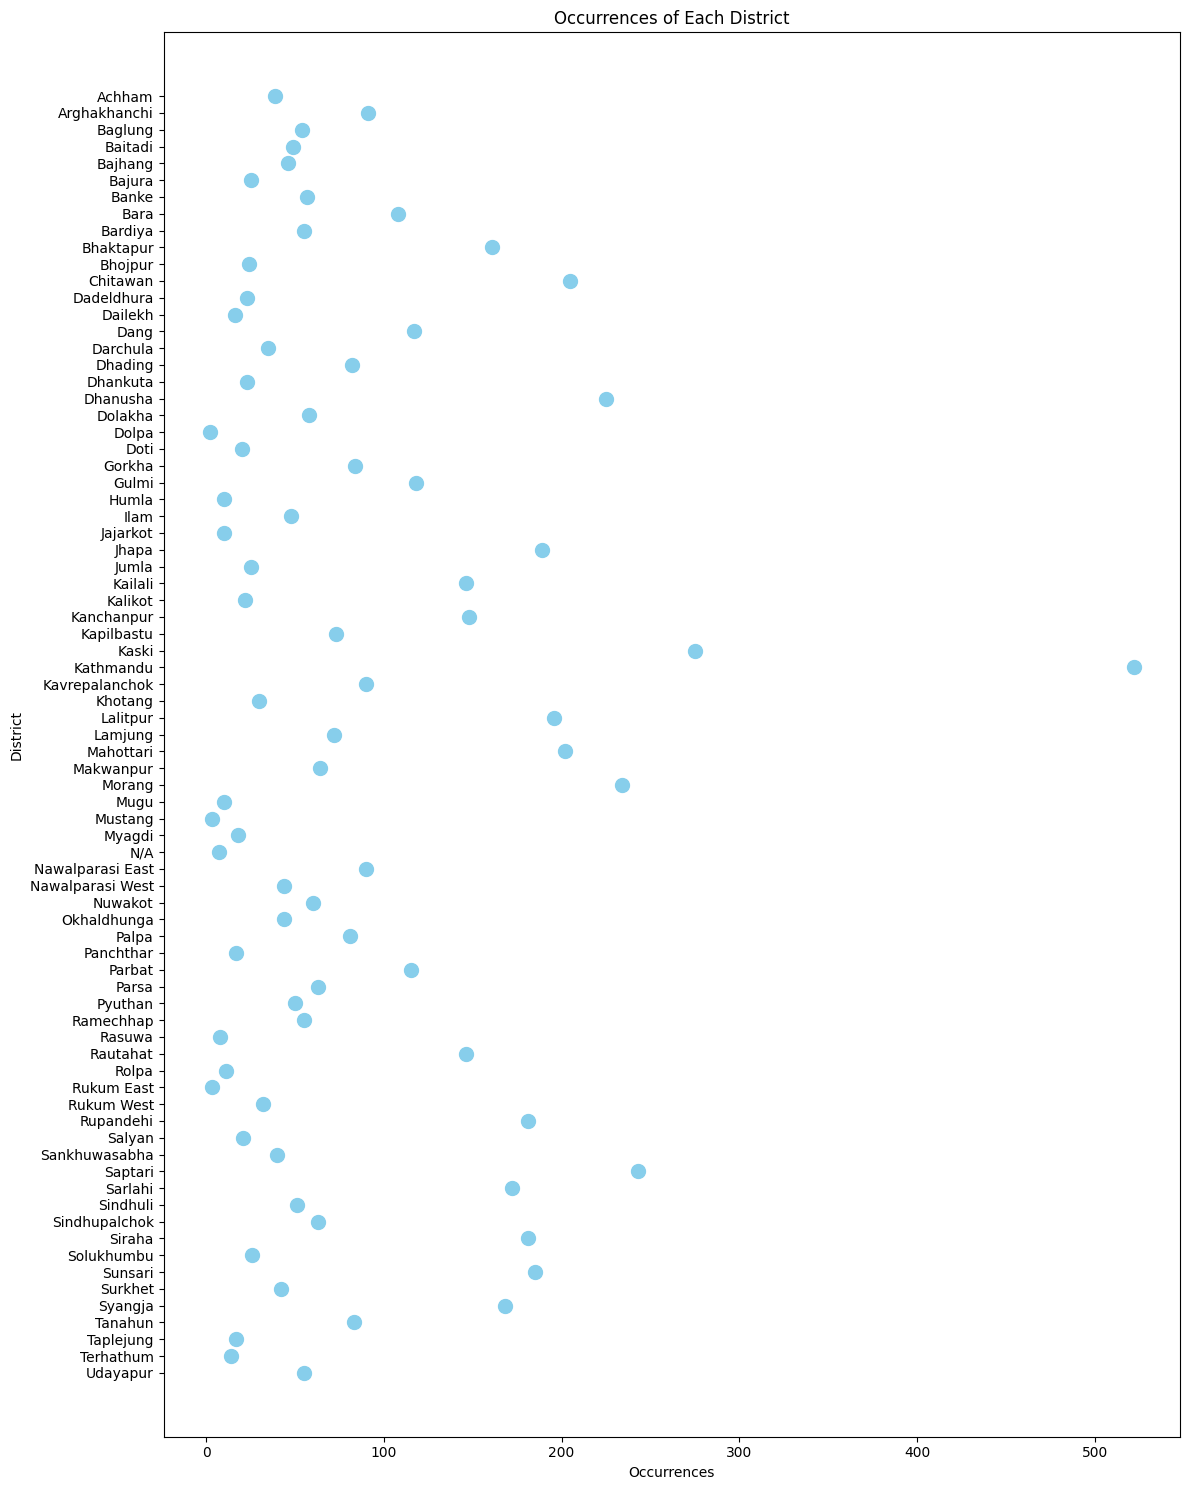

In [267]:
# Plotting Dot Plot
plt.figure(figsize=(12, 15))
plt.scatter(district_counts['Occurrences'], district_counts['District'], color='skyblue', s=100)
plt.xlabel('Occurrences')
plt.ylabel('District')
plt.title('Occurrences of Each District')
plt.tight_layout()
plt.show()  # Display plot in Colab

plt.close()

In [268]:

district_counts = district_counts.sort_values(by='District', ascending=False)

# Plotting Interactive Bar Chart ordered by District
fig = px.bar(district_counts, x='Occurrences', y='District',
             title='Total Candidates from Each District',
             labels={'Occurrences': 'Number of Occurrences', 'District': 'District'},
             orientation='h')

fig.update_layout(yaxis_title='District', xaxis_title='Candidates',
                  height=2000)  # Adjust height for better visibility
fig.update_traces(marker_color='skyblue')

In [269]:
# Group by District and Gender, then count occurrences
gender_distribution = df.groupby(['District', 'Gender']).size().unstack(fill_value=0)

# Find total number of candidates per district
gender_distribution['Total'] = gender_distribution['Male'] + gender_distribution['Female']


In [270]:
# Calculate gender distribution
gender_distribution = df.groupby(['District', 'Gender']).size().unstack(fill_value=0)

# Find total number of candidates per district
gender_distribution['Total'] = gender_distribution['Male'] + gender_distribution['Female']

# Reset index to prepare for plotting
district_counts = gender_distribution.reset_index()

# Plotting Interactive Bar Chart for Gender Distribution
fig = px.bar(district_counts,
             x=['Male', 'Female'],  # Display separate bars for Male and Female
             y='District',
             title='Number of Candidates by Gender for Each District',
             labels={'value': 'Number of Candidates', 'District': 'District', 'variable': 'Gender'},
             height=2000,  # Adjust height for better visibility
             orientation='h',
             color_discrete_map={'Male': '#66b3ff', 'Female': 'pink'})  # Color for each gender

fig.update_layout(xaxis_title='District', yaxis_title='Number of Candidates')

# Show plot in Colab
fig.show()




In [271]:
value_counts = df['District'].str.upper()
value_counts = value_counts.value_counts().reset_index()
value_counts.columns = ['District', 'Value']
value_counts.head()

,District,Value
0,KATHMANDU,522
1,KASKI,275
2,SAPTARI,243
3,MORANG,234
4,DHANUSHA,225


In [272]:

# Load GeoJSON for Nepal districts
geojson_path = 'https://raw.githubusercontent.com/rishavgautam/IOEResult2024/main/nepal-with-districts.geojson'
gdf = gpd.read_file(geojson_path)

# Define bins and colors
# Merge your data with the GeoDataFrame
gdf = gdf.merge(value_counts, left_on='DISTRICT', right_on='District', how='left')

# Create a Folium map
m = folium.Map(location=[28.3949, 84.1240], zoom_start=7.4)  # Centered on Nepal

# Add a Choropleth layer
folium.Choropleth(
    geo_data=gdf,
    data=gdf,
    # bins=bins,
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Candidates',
    columns=['District', 'Value'],
    key_on='feature.properties.DISTRICT',  # Property name from GeoJSON
).add_to(m)

# Add popups to the map
for _, row in gdf.iterrows():
    folium.Popup(f"{row['DISTRICT']}: {row['Value']}").add_to(
        folium.Marker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            popup=f"{row['DISTRICT']}: {row['Value']}"
        ).add_to(m)
    )

m

